In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e1-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [ ]:
num_samples=10

Correlation-Aware Sparse Bayesian Learning (CA-SBL)

In [ ]:
def casbl_algorithm(A, y, N, sig2e, Tau_p, loc, alpha=1, beta=0.2, kappa=5.725, D=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if kappa == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / kappa) - np.exp(-D / kappa)) / (1 - np.exp(-D / kappa)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
        mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

        # Compute Q (denoted as B in the image)
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P (denoted as A_3 in the image)
        P = alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
    mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [ ]:
# Placeholder arrays for casbl results
z_casbl = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # casbl results
gamma_casbl = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # casbl gamma values
hit_rate_casbl = np.zeros((num_samples, len(pilot_length_array)))  # Hit rate for casbl
support_recovery_rate_casbl = np.zeros((num_samples, len(pilot_length_array)))  # Miss detection rate for casbl
false_alarm_rate_casbl = np.zeros((num_samples, len(pilot_length_array)))  # False alarm rate for casbl
norm_mse_casbl = np.zeros((num_samples, len(pilot_length_array)))  # Norm MSE for casbl

In [ ]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply casbl algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length, loc)

        # Store the results
        z_result[gamma_result <= 0.05] = 0
        z_casbl[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_casbl[sample_index, pilot_length_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for casbl
        hit_rate_casbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the support recovery rate for casbl
        support_recovery_rate_casbl[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool ==1) & (gamma == 1))
            /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Calculate the false alarm rate for casbl
        false_alarm_rate_casbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for casbl
        norm_mse_casbl[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )  # Avoid division by zero


Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:49, 16.37s/it]

Converged after 486 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:08<00:35, 17.50s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.97s/it]

Converged after 441 outer iterations



Processing Samples:  10%|█         | 1/10 [01:32<13:51, 92.43s/it]

Converged after 250 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.01s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.86s/it]

Converged after 473 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.87s/it]

Converged after 354 outer iterations



Processing Samples:  20%|██        | 2/10 [03:01<12:01, 90.24s/it]

Converged after 273 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.92s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.15s/it]

Converged after 337 outer iterations



Processing Samples:  30%|███       | 3/10 [04:27<10:18, 88.41s/it]

Converged after 280 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.93s/it]

Converged after 325 outer iterations



Processing Samples:  40%|████      | 4/10 [06:02<09:06, 91.03s/it]

Converged after 487 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.99s/it]

Converged after 432 outer iterations



Processing Samples:  50%|█████     | 5/10 [07:37<07:42, 92.44s/it]

Converged after 269 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.94s/it]

Converged after 354 outer iterations



Processing Samples:  60%|██████    | 6/10 [09:09<06:09, 92.27s/it]

Converged after 277 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:50, 16.88s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:34, 17.09s/it]

Converged after 472 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.24s/it]

Converged after 295 outer iterations



Processing Samples:  70%|███████   | 7/10 [10:38<04:33, 91.16s/it]

Converged after 288 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.26s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.76s/it]

Converged after 375 outer iterations



Processing Samples:  80%|████████  | 8/10 [12:06<03:00, 90.24s/it]

Converged after 298 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.59s/it]

Converged after 344 outer iterations



Processing Samples:  90%|█████████ | 9/10 [13:37<01:30, 90.39s/it]

Converged after 254 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.86s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.88s/it]

Converged after 325 outer iterations



Processing Samples: 100%|██████████| 10/10 [15:08<00:00, 90.82s/it]

Converged after 360 outer iterations


In [ ]:
# Compute the average across all samples for each SNR level
avg_hit_rate_casbl = np.mean(hit_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_support_recovery_rate_casbl = np.mean(support_recovery_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_casbl = np.mean(false_alarm_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_casbl = np.mean(norm_mse_casbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_casbl)
print("Average Support Recovery Rate across samples per SNR level:", avg_support_recovery_rate_casbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_casbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_casbl)

Average Hit Rate across samples per SNR level: [ 45.  92. 100. 100. 100. 100.]
Average Support Recovery Rate across samples per SNR level: [0.26125269 0.67254789 0.9469697  0.95606061 0.98333333 0.99090909]
Average False Alarm Rate across samples per SNR level: [1.66666667 0.97435897 0.15384615 0.12820513 0.05128205 0.02564103]
Average Normalized MSE across samples per SNR level: [0.66218171 0.280765   0.0626416  0.04060592 0.0296909  0.02371779]


In [ ]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/data/results/e1-results-10-casbl-banc-alpha-1-0-beta-0-2-pilot-length-all-snr-db-12.npz',
                    z_casbl=z_casbl,
                    gamma_casbl=gamma_casbl,
                    hit_rate_casbl=hit_rate_casbl,
                    support_recovery_rate_casbl=support_recovery_rate_casbl,
                    false_alarm_rate_casbl=false_alarm_rate_casbl,
                    norm_mse_casbl=norm_mse_casbl,
                    avg_hit_rate_casbl=avg_hit_rate_casbl,
                    avg_support_recovery_rate_casbl=avg_support_recovery_rate_casbl,
                    avg_false_alarm_rate_casbl=avg_false_alarm_rate_casbl,
                    avg_norm_mse_casbl=avg_norm_mse_casbl,
                    pilot_length_array=pilot_length_array,
                    snr_db=snr_db)

print("All results have been saved to 'communication_simulation_results_all_samples.npz'.")

All results have been saved to 'communication_simulation_results_all_samples.npz'.


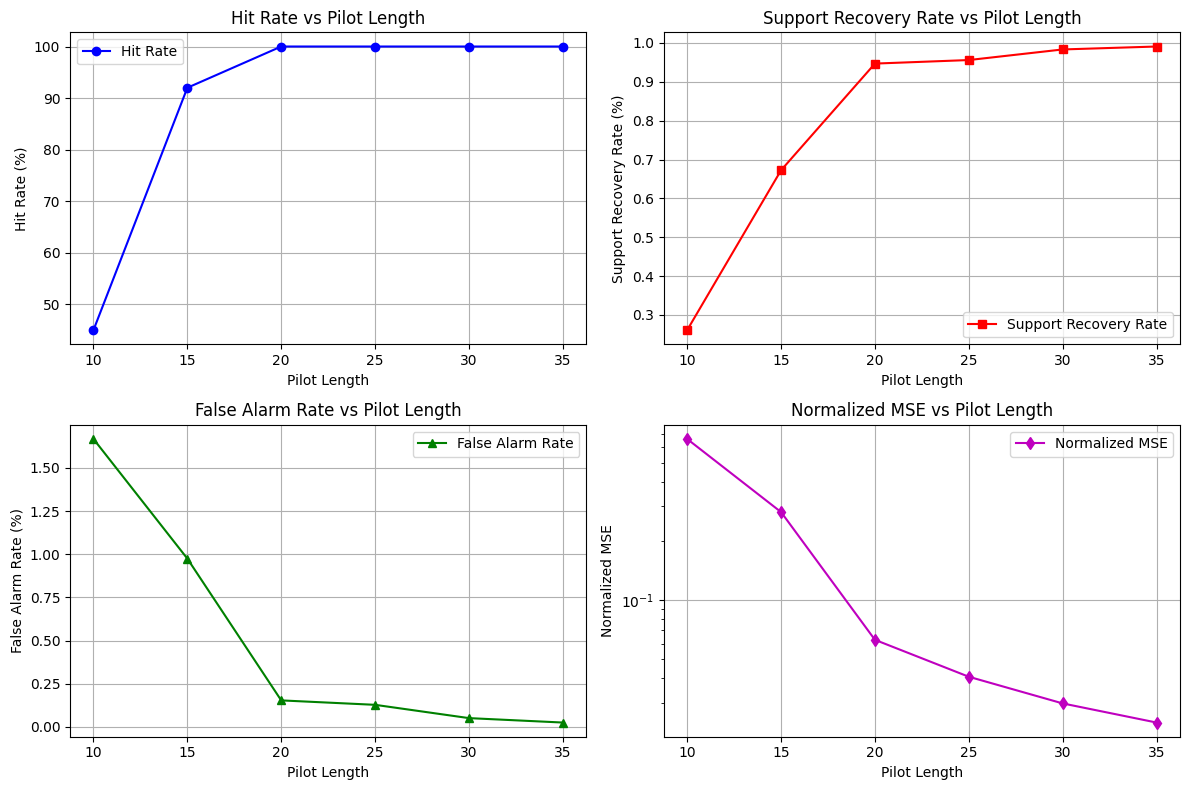

In [ ]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(pilot_length_values, avg_hit_rate_casbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Miss Detection Rate
plt.subplot(2, 2, 2)
plt.plot(pilot_length_values, avg_support_recovery_rate_casbl, marker='s', linestyle='-', color='r', label='Support Recovery Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate (%)")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(pilot_length_values, avg_false_alarm_rate_casbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(pilot_length_values, avg_norm_mse_casbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
